# Analysing music preference in Spotify with ANOVA

Εμπνευσμένο από το άρθρο του Economist [Data from Spotify suggest that listeners are gloomiest in February](https://www.economist.com/graphic-detail/2020/02/08/data-from-spotify-suggest-that-listeners-are-gloomiest-in-february).

* We want to explore the most popular music tracks in the world.

* These are provided by [Spotify Charts](https://spotifycharts.com/).

* Unfortunately, although the data is available in CSV format, we can only download data for each individual week.

* Fortunately, data for some countries and for the entire world, for the period 2017-2019, is available at Zenodo https://doi.org/10.5281/zenodo.4778562:

 * Gabriel P. Oliveira, Mariana O. Silva, Danilo B. Seufitelli, Anisio Lacerda, and Mirella M. Moro. Detecting Collaboration Profiles in Success-based Music Genre Networks. In Proceedings of the 21st International Society for Music Information Retrieval Conference (ISMIR 2020), 2020.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re
from datetime import datetime

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

* So from Zenodo we can download the file with the popular tracks (`charts.zip`).

* If we unzip the file, we will see that it places the files for each region in a separate directory.

* In each directory, data is stored in weekly files.

* We will read them all, recording the week and region.

In [2]:
header = 0
dfs = []
for file in glob.glob('Charts/*/201?/*.csv'):
    region = file.split('/')[1]
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region
    dfs.append(weekly_chart)

all_charts = pd.concat(dfs)

In [3]:
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region
0,1,7wGoVu4Dady5GV0Sv4UIsx,rockstar,Post Malone,17532665,1.0,3,1,0,2017-10-20,2017-10-27,us
1,2,75ZvA4QfFiZvzhj2xkaWAh,I Fall Apart,Post Malone,8350785,2.0,6,2,0,2017-10-20,2017-10-27,us
2,3,2fQrGHiQOvpL9UgPvtYy6G,Bank Account,21 Savage,7589124,4.0,5,3,1,2017-10-20,2017-10-27,us
3,4,43ZyHQITOjhciSUUNPVRHc,Gucci Gang,Lil Pump,7584237,5.0,3,4,1,2017-10-20,2017-10-27,us
4,5,5tz69p7tJuGPeMGwNTxYuV,1-800-273-8255,Logic,7527770,3.0,26,1,-2,2017-10-20,2017-10-27,us
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,6kex4EBAj0WHXDKZMEJaaF,Swalla (feat. Nicki Minaj & Ty Dolla $ign),Jason Derulo,3747830,191.0,52,8,-5,2018-03-02,2018-03-09,global
196,197,0CokSRCu5hZgPxcZBaEzVE,Glorious (feat. Skylar Grey),Macklemore,3725286,189.0,24,14,-8,2018-03-02,2018-03-09,global
197,198,7oK9VyNzrYvRFo7nQEYkWN,Mr. Brightside,The Killers,3717326,195.0,17,148,-3,2018-03-02,2018-03-09,global
198,199,7EUfNvyCVxQV3oN5ScA2Lb,Next To Me,Imagine Dragons,3681739,122.0,2,122,-77,2018-03-02,2018-03-09,global


* There are tons of tracks, but not all of them are unique:

In [4]:
len(all_charts['song_id'].unique())

13880

* Θα φτιάξουμε ένα αρχείο`spotify_config.py` με τα ακόλουθα περιεχόμενα (όπου `XXX` θα βάλουμε τα δικά μας στοιχεία):

  ```
  config = {
      'client_id' : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
      'client_secret' :'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
  }
  ```

* Now we can start using the Spotify API through the [Spotipy](https://spotipy.readthedocs.io) library.

In [5]:
from spotify_config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

* For each of the tracks we have we will request its audio features, or [audio features](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-several-audio-features ).

* To do this, we will make a dictionary where keys will be `song_id` and values ​​will be the audio characteristics of the corresponding track.

In [6]:
features = {}

* The call that gives us audio features can request up to 100 at a time, so we should request them in batches of 100.

In [7]:
all_track_ids = list(all_charts['song_id'].unique())
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200
getting from 1200 to 1300
getting from 1300 to 1400
getting from 1400 to 1500
getting from 1500 to 1600
getting from 1600 to 1700
getting from 1700 to 1800
getting from 1800 to 1900
getting from 1900 to 2000
getting from 2000 to 2100
getting from 2100 to 2200
getting from 2200 to 2300
getting from 2300 to 2400
getting from 2400 to 2500
getting from 2500 to 2600
getting from 2600 to 2700
getting from 2700 to 2800
getting from 2800 to 2900
getting from 2900 to 3000
getting from 3000 to 3100
getting from 3100 to 3200
getting from 3200 to 3300
getting from 3300 to 3400
getting from 3400 to 3500
getting from 3500 to 3600
getting from 3600 to 3700
getting from 3700 to 3800
getting from 3800 to 3900
getting

* Let's confirm we got everything:

In [8]:
len(features)

13880

* Here's what the audio specs look like.

* We will deal with *valence*, which corresponds to the positive mood that a piece exudes.

In [9]:
features['1mqlc0vEP9mU1kZgTi6LIQ'] # September by Earth, Wind & Fire

{'danceability': 0.693,
 'energy': 0.911,
 'key': 9,
 'loudness': -3.691,
 'mode': 1,
 'speechiness': 0.0305,
 'acousticness': 0.183,
 'instrumentalness': 0.000107,
 'liveness': 0.3,
 'valence': 0.982,
 'tempo': 125.895,
 'type': 'audio_features',
 'id': '1mqlc0vEP9mU1kZgTi6LIQ',
 'uri': 'spotify:track:1mqlc0vEP9mU1kZgTi6LIQ',
 'track_href': 'https://api.spotify.com/v1/tracks/1mqlc0vEP9mU1kZgTi6LIQ',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1mqlc0vEP9mU1kZgTi6LIQ',
 'duration_ms': 216520,
 'time_signature': 4}

* We will now convert the dictionary to a `DataFrame`.

In [10]:
tracks = pd.DataFrame.from_dict(features, orient='index')
tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
7wGoVu4Dady5GV0Sv4UIsx,0.577,0.522,5,-6.594,0,0.0984,0.1300,0.000090,0.1420,0.119,159.772,audio_features,7wGoVu4Dady5GV0Sv4UIsx,spotify:track:7wGoVu4Dady5GV0Sv4UIsx,https://api.spotify.com/v1/tracks/7wGoVu4Dady5...,https://api.spotify.com/v1/audio-analysis/7wGo...,218320,4
75ZvA4QfFiZvzhj2xkaWAh,0.556,0.538,8,-5.408,0,0.0382,0.0689,0.000000,0.1960,0.291,143.950,audio_features,75ZvA4QfFiZvzhj2xkaWAh,spotify:track:75ZvA4QfFiZvzhj2xkaWAh,https://api.spotify.com/v1/tracks/75ZvA4QfFiZv...,https://api.spotify.com/v1/audio-analysis/75Zv...,223347,4
2fQrGHiQOvpL9UgPvtYy6G,0.884,0.346,8,-8.228,0,0.3510,0.0151,0.000007,0.0871,0.376,75.016,audio_features,2fQrGHiQOvpL9UgPvtYy6G,spotify:track:2fQrGHiQOvpL9UgPvtYy6G,https://api.spotify.com/v1/tracks/2fQrGHiQOvpL...,https://api.spotify.com/v1/audio-analysis/2fQr...,220307,4
43ZyHQITOjhciSUUNPVRHc,0.936,0.523,5,-6.710,1,0.0597,0.2390,0.000000,0.1170,0.699,119.889,audio_features,43ZyHQITOjhciSUUNPVRHc,spotify:track:43ZyHQITOjhciSUUNPVRHc,https://api.spotify.com/v1/tracks/43ZyHQITOjhc...,https://api.spotify.com/v1/audio-analysis/43Zy...,124056,4
5tz69p7tJuGPeMGwNTxYuV,0.620,0.574,5,-7.788,0,0.0479,0.5690,0.000000,0.1900,0.357,100.023,audio_features,5tz69p7tJuGPeMGwNTxYuV,spotify:track:5tz69p7tJuGPeMGwNTxYuV,https://api.spotify.com/v1/tracks/5tz69p7tJuGP...,https://api.spotify.com/v1/audio-analysis/5tz6...,250173,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3js3wKPw8VxBWtcXtwyUnA,0.798,0.627,9,-6.234,1,0.1110,0.2630,0.000000,0.2110,0.762,149.989,audio_features,3js3wKPw8VxBWtcXtwyUnA,spotify:track:3js3wKPw8VxBWtcXtwyUnA,https://api.spotify.com/v1/tracks/3js3wKPw8VxB...,https://api.spotify.com/v1/audio-analysis/3js3...,195947,4
4VVG3HBGaqSNZqIpmewIA6,0.777,0.721,6,-6.097,1,0.0719,0.0774,0.000000,0.0801,0.665,161.976,audio_features,4VVG3HBGaqSNZqIpmewIA6,spotify:track:4VVG3HBGaqSNZqIpmewIA6,https://api.spotify.com/v1/tracks/4VVG3HBGaqSN...,https://api.spotify.com/v1/audio-analysis/4VVG...,205013,4
6csZYoffpZ7iuSw83x2zVy,0.913,0.788,10,-2.889,0,0.2630,0.0546,0.000640,0.1680,0.544,120.934,audio_features,6csZYoffpZ7iuSw83x2zVy,spotify:track:6csZYoffpZ7iuSw83x2zVy,https://api.spotify.com/v1/tracks/6csZYoffpZ7i...,https://api.spotify.com/v1/audio-analysis/6csZ...,143314,4
0kHTkvGavvk2MjBTSUtOZx,0.599,0.734,3,-7.568,0,0.4130,0.1960,0.000000,0.1870,0.133,211.842,audio_features,0kHTkvGavvk2MjBTSUtOZx,spotify:track:0kHTkvGavvk2MjBTSUtOZx,https://api.spotify.com/v1/tracks/0kHTkvGavvk2...,https://api.spotify.com/v1/audio-analysis/0kHT...,223787,4


* The index contains the code of each track, as does the `id` column, so we'll keep one of the two.

In [11]:
tracks = tracks.reset_index(drop=True).rename(columns={'id' : 'song_id'})
tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,song_id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.577,0.522,5,-6.594,0,0.0984,0.1300,0.000090,0.1420,0.119,159.772,audio_features,7wGoVu4Dady5GV0Sv4UIsx,spotify:track:7wGoVu4Dady5GV0Sv4UIsx,https://api.spotify.com/v1/tracks/7wGoVu4Dady5...,https://api.spotify.com/v1/audio-analysis/7wGo...,218320,4
1,0.556,0.538,8,-5.408,0,0.0382,0.0689,0.000000,0.1960,0.291,143.950,audio_features,75ZvA4QfFiZvzhj2xkaWAh,spotify:track:75ZvA4QfFiZvzhj2xkaWAh,https://api.spotify.com/v1/tracks/75ZvA4QfFiZv...,https://api.spotify.com/v1/audio-analysis/75Zv...,223347,4
2,0.884,0.346,8,-8.228,0,0.3510,0.0151,0.000007,0.0871,0.376,75.016,audio_features,2fQrGHiQOvpL9UgPvtYy6G,spotify:track:2fQrGHiQOvpL9UgPvtYy6G,https://api.spotify.com/v1/tracks/2fQrGHiQOvpL...,https://api.spotify.com/v1/audio-analysis/2fQr...,220307,4
3,0.936,0.523,5,-6.710,1,0.0597,0.2390,0.000000,0.1170,0.699,119.889,audio_features,43ZyHQITOjhciSUUNPVRHc,spotify:track:43ZyHQITOjhciSUUNPVRHc,https://api.spotify.com/v1/tracks/43ZyHQITOjhc...,https://api.spotify.com/v1/audio-analysis/43Zy...,124056,4
4,0.620,0.574,5,-7.788,0,0.0479,0.5690,0.000000,0.1900,0.357,100.023,audio_features,5tz69p7tJuGPeMGwNTxYuV,spotify:track:5tz69p7tJuGPeMGwNTxYuV,https://api.spotify.com/v1/tracks/5tz69p7tJuGP...,https://api.spotify.com/v1/audio-analysis/5tz6...,250173,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13875,0.798,0.627,9,-6.234,1,0.1110,0.2630,0.000000,0.2110,0.762,149.989,audio_features,3js3wKPw8VxBWtcXtwyUnA,spotify:track:3js3wKPw8VxBWtcXtwyUnA,https://api.spotify.com/v1/tracks/3js3wKPw8VxB...,https://api.spotify.com/v1/audio-analysis/3js3...,195947,4
13876,0.777,0.721,6,-6.097,1,0.0719,0.0774,0.000000,0.0801,0.665,161.976,audio_features,4VVG3HBGaqSNZqIpmewIA6,spotify:track:4VVG3HBGaqSNZqIpmewIA6,https://api.spotify.com/v1/tracks/4VVG3HBGaqSN...,https://api.spotify.com/v1/audio-analysis/4VVG...,205013,4
13877,0.913,0.788,10,-2.889,0,0.2630,0.0546,0.000640,0.1680,0.544,120.934,audio_features,6csZYoffpZ7iuSw83x2zVy,spotify:track:6csZYoffpZ7iuSw83x2zVy,https://api.spotify.com/v1/tracks/6csZYoffpZ7i...,https://api.spotify.com/v1/audio-analysis/6csZ...,143314,4
13878,0.599,0.734,3,-7.568,0,0.4130,0.1960,0.000000,0.1870,0.133,211.842,audio_features,0kHTkvGavvk2MjBTSUtOZx,spotify:track:0kHTkvGavvk2MjBTSUtOZx,https://api.spotify.com/v1/tracks/0kHTkvGavvk2...,https://api.spotify.com/v1/audio-analysis/0kHT...,223787,4


* We can now merge the valences of each piece with the data from Zenodo.

In [12]:
all_charts = pd.merge(all_charts, tracks[['song_id', 'valence']], on='song_id', how='left')
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region,valence
0,1,7wGoVu4Dady5GV0Sv4UIsx,rockstar,Post Malone,17532665,1.0,3,1,0,2017-10-20,2017-10-27,us,0.119
1,2,75ZvA4QfFiZvzhj2xkaWAh,I Fall Apart,Post Malone,8350785,2.0,6,2,0,2017-10-20,2017-10-27,us,0.291
2,3,2fQrGHiQOvpL9UgPvtYy6G,Bank Account,21 Savage,7589124,4.0,5,3,1,2017-10-20,2017-10-27,us,0.376
3,4,43ZyHQITOjhciSUUNPVRHc,Gucci Gang,Lil Pump,7584237,5.0,3,4,1,2017-10-20,2017-10-27,us,0.699
4,5,5tz69p7tJuGPeMGwNTxYuV,1-800-273-8255,Logic,7527770,3.0,26,1,-2,2017-10-20,2017-10-27,us,0.357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
273595,196,6kex4EBAj0WHXDKZMEJaaF,Swalla (feat. Nicki Minaj & Ty Dolla $ign),Jason Derulo,3747830,191.0,52,8,-5,2018-03-02,2018-03-09,global,0.782
273596,197,0CokSRCu5hZgPxcZBaEzVE,Glorious (feat. Skylar Grey),Macklemore,3725286,189.0,24,14,-8,2018-03-02,2018-03-09,global,0.356
273597,198,7oK9VyNzrYvRFo7nQEYkWN,Mr. Brightside,The Killers,3717326,195.0,17,148,-3,2018-03-02,2018-03-09,global,0.232
273598,199,7EUfNvyCVxQV3oN5ScA2Lb,Next To Me,Imagine Dragons,3681739,122.0,2,122,-77,2018-03-02,2018-03-09,global,0.351


* As we said, we are interested in valence, in the `valence' column.

* Let's see the strength by week:

In [13]:
weekly_valence = all_charts.groupby('week_start').mean()['valence']
weekly_valence

week_start
2016-12-30    0.502642
2017-01-06    0.493741
2017-01-13    0.490104
2017-01-20    0.488434
2017-01-27    0.490052
                ...   
2019-11-22    0.526818
2019-11-29    0.531499
2019-12-06    0.534468
2019-12-13    0.536318
2019-12-20    0.544564
Name: valence, Length: 156, dtype: float64

* During the year:

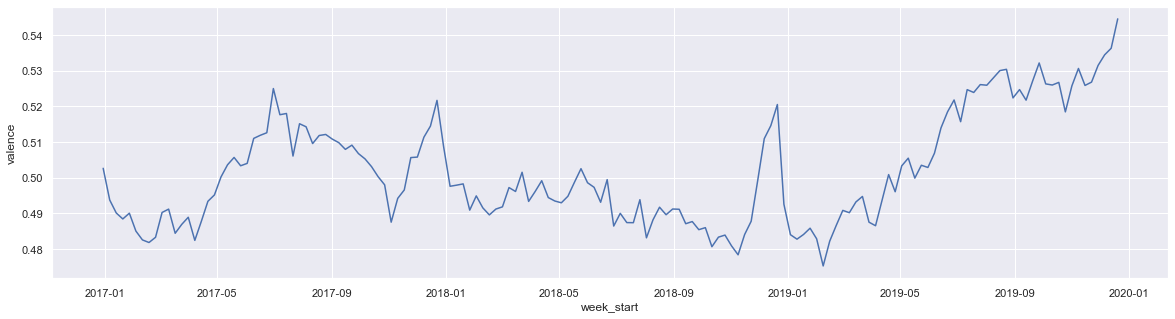

In [14]:
sns.set_theme()
plt.figure(figsize=(20,5))
_ = sns.lineplot(x=weekly_valence.index, y=weekly_valence)

* How important Christmas is!

* And what a melancholy month February seems to be...

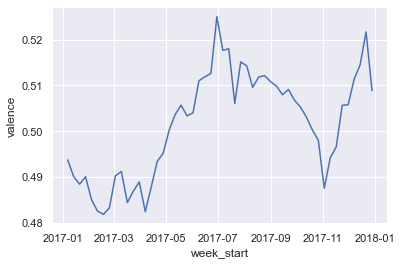

In [15]:
weekly_valence_2017 = weekly_valence[weekly_valence.index.year == 2017]
_ = sns.lineplot(x=weekly_valence_2017.index, y=weekly_valence_2017)

* We see the same next year!

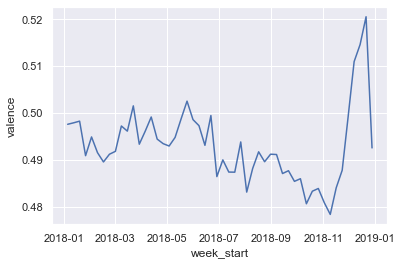

In [16]:
weekly_valence_2018 = weekly_valence[weekly_valence.index.year == 2018]
_ = sns.lineplot(x=weekly_valence_2018.index, y=weekly_valence_2018)

* But we don't see it in 2019.

* People seem to be having fun in general, apparently they had no idea what was coming in 2020...

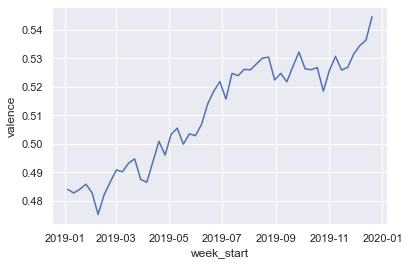

In [17]:
weekly_valence_2019 = weekly_valence[weekly_valence.index.year == 2019]
_ = sns.lineplot(x=weekly_valence_2019.index, y=weekly_valence_2019)

* More generally, however, the strength of the pieces seems to be towards the middle.

<AxesSubplot:xlabel='valence', ylabel='Count'>

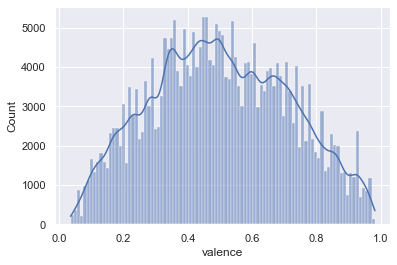

In [18]:
sns.histplot(x='valence', data=all_charts, kde=True)

* We can see the image in a specific region, such as in the US:

<AxesSubplot:xlabel='valence', ylabel='Count'>

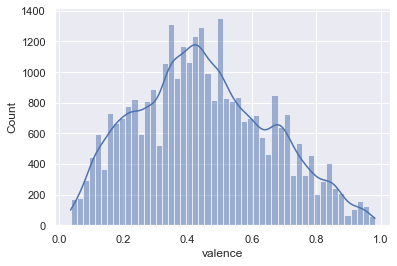

In [19]:
sns.histplot(x='valence', data=all_charts[all_charts['region'] == 'us'], kde=True)

* Or in Brazil:

<AxesSubplot:xlabel='valence', ylabel='Count'>

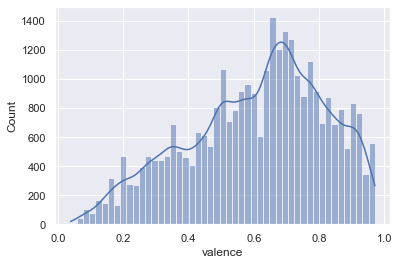

In [20]:
sns.histplot(x='valence', data=all_charts[all_charts['region'] == 'br'], kde=True)

* Or in all regions together:

<Figure size 1152x720 with 0 Axes>

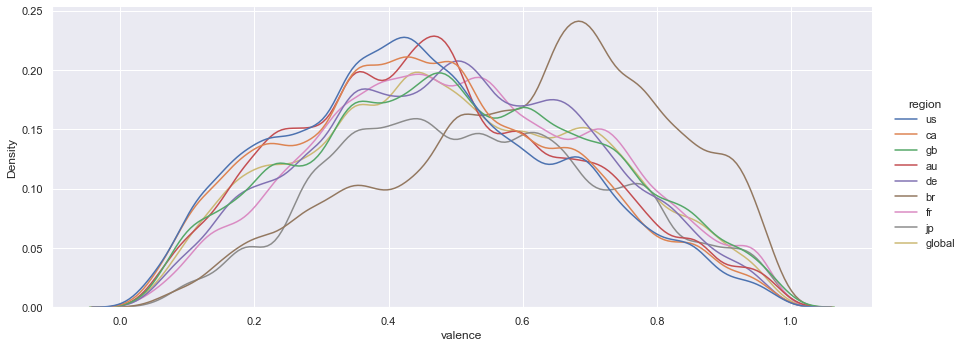

In [21]:
plt.figure(figsize=(16, 10))
_ = sns.displot(x="valence", data=all_charts, hue="region", aspect=2.5, kind="kde")

* Or in the US, Brazil, and worldwide:

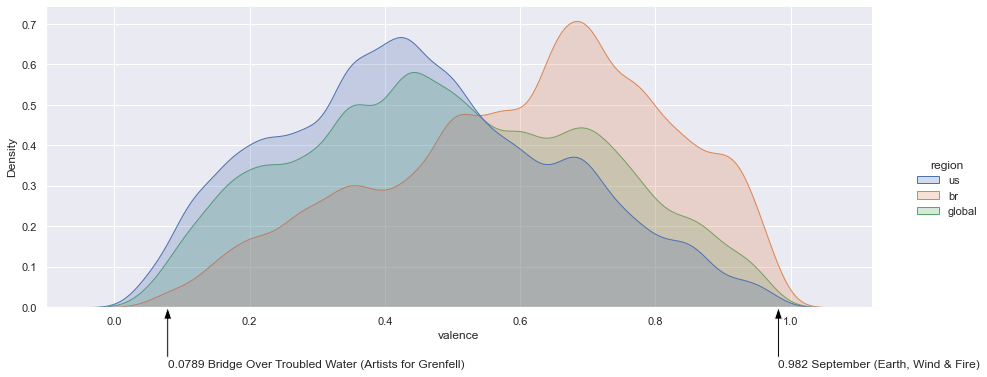

In [22]:
g = sns.displot(x="valence", data=all_charts[all_charts['region'].isin(['br', 'us', 'global'])], 
                hue="region", aspect=2.5, kind="kde", fill=True)
g.ax.annotate('0.0789 Bridge Over Troubled Water (Artists for Grenfell)', 
              xy=(0.0789, 0.0), 
              xytext=(0.0789, -0.15), 
              arrowprops=dict(facecolor='black', headwidth=8, width=2),
)
_ = g.ax.annotate('0.982 September (Earth, Wind & Fire)', xy=(0.982, 0.0), 
                  xytext=(0.982, -0.15),
                  arrowprops=dict(facecolor='black', headwidth=8, width=2))

* The thecograms can show us the size of the difference by region:

<AxesSubplot:xlabel='region', ylabel='valence'>

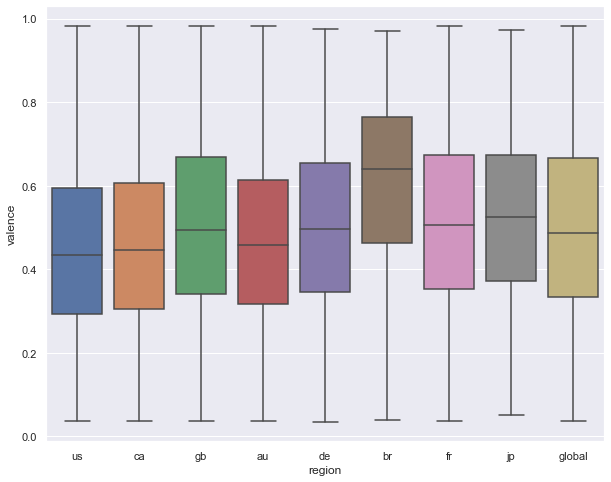

In [23]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='region', y='valence', data=all_charts)

* One idea is to put all the histograms in one chart, but in a better way.

* We'll start by taking the average valence in ascending order.

In [24]:
valence_by_region = all_charts[['region', 'valence']].groupby('region').mean().sort_values(by='valence')
valence_by_region.reset_index(inplace=True)
valence_by_region['region_valence_pos'] = valence_by_region.index
valence_by_region

,region,valence,region_valence_pos
0,us,0.450253,0
1,ca,0.459242,1
2,au,0.469923,2
3,global,0.495207,3
4,de,0.499084,4
5,gb,0.501666,5
6,fr,0.510750,6
7,jp,0.529292,7
8,br,0.606860,8


* We will add the position of each region, in terms of valence, to the `DataFrame` `all_charts`.

In [25]:
all_charts = pd.merge(all_charts, valence_by_region[['region', 'region_valence_pos']], on='region')
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region,valence,region_valence_pos
0,1,7wGoVu4Dady5GV0Sv4UIsx,rockstar,Post Malone,17532665,1.0,3,1,0,2017-10-20,2017-10-27,us,0.119,0
1,2,75ZvA4QfFiZvzhj2xkaWAh,I Fall Apart,Post Malone,8350785,2.0,6,2,0,2017-10-20,2017-10-27,us,0.291,0
2,3,2fQrGHiQOvpL9UgPvtYy6G,Bank Account,21 Savage,7589124,4.0,5,3,1,2017-10-20,2017-10-27,us,0.376,0
3,4,43ZyHQITOjhciSUUNPVRHc,Gucci Gang,Lil Pump,7584237,5.0,3,4,1,2017-10-20,2017-10-27,us,0.699,0
4,5,5tz69p7tJuGPeMGwNTxYuV,1-800-273-8255,Logic,7527770,3.0,26,1,-2,2017-10-20,2017-10-27,us,0.357,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273595,196,6kex4EBAj0WHXDKZMEJaaF,Swalla (feat. Nicki Minaj & Ty Dolla $ign),Jason Derulo,3747830,191.0,52,8,-5,2018-03-02,2018-03-09,global,0.782,3
273596,197,0CokSRCu5hZgPxcZBaEzVE,Glorious (feat. Skylar Grey),Macklemore,3725286,189.0,24,14,-8,2018-03-02,2018-03-09,global,0.356,3
273597,198,7oK9VyNzrYvRFo7nQEYkWN,Mr. Brightside,The Killers,3717326,195.0,17,148,-3,2018-03-02,2018-03-09,global,0.232,3
273598,199,7EUfNvyCVxQV3oN5ScA2Lb,Next To Me,Imagine Dragons,3681739,122.0,2,122,-77,2018-03-02,2018-03-09,global,0.351,3


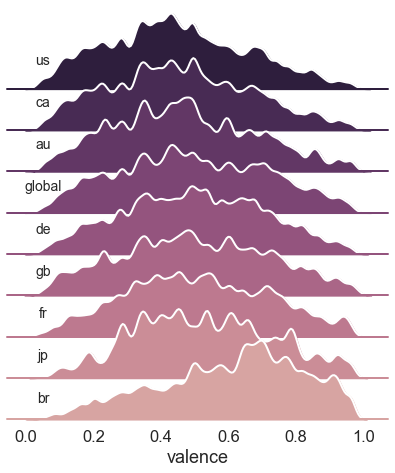

In [26]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)
pal = sns.cubehelix_palette(len(valence_by_region), rot=.45, light=.7, reverse=True)
g = sns.FacetGrid(all_charts, 
                  row='region', 
                  hue='region_valence_pos',
                  row_order=valence_by_region['region'],
                  height=0.8, aspect=8,
                  palette=pal)
g.map(sns.kdeplot, "valence",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "valence", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
for i, region in enumerate(reversed(valence_by_region['region'])):
    plt.text(0.05, 0.5 + 1.2*i, region,
             horizontalalignment='center',
             fontsize=14)

### It is obvious that the strength varies from region to region.

### But are these differences statistically significant?

* To clarify this we will use Analysis of Variance (ANOVA).

* In ANOVA we control the within-groups variation against the between-groups variation of our data.
### If the between-group variation is large relative to the within-group variation, then it is unlikely that the differences in mean values ​​are simply a product of chance.

* To use ANOVA some conditions must be met.

* A condition is that the data in each group must follow a normal distribution.

* To check this we first construct histograms for each group, i.e. region.

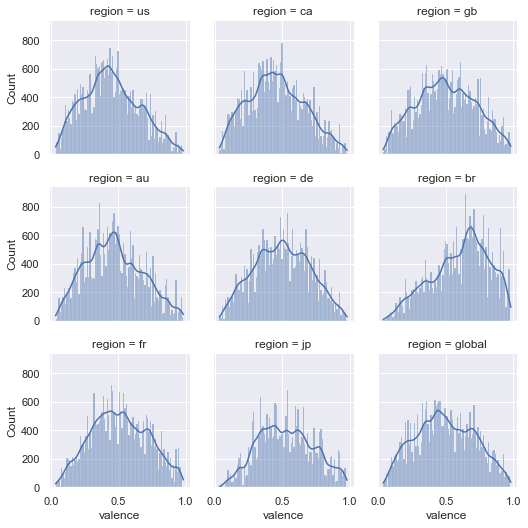

In [27]:
sns.set_theme()
_ = sns.displot(all_charts, kde=True,
    x="valence", col="region", col_wrap=3, height=2.5, facet_kws=dict(margin_titles=True),
)

* We proceed to construct QQ charts, one per region.

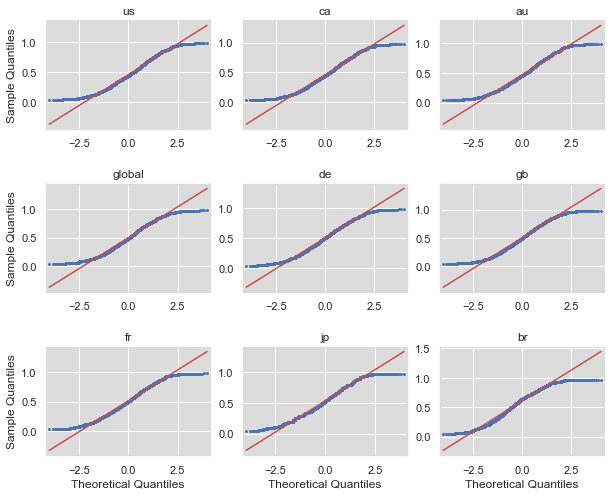

In [28]:
fig = plt.figure(figsize=(10, 8))
plt.rc('axes', edgecolor='gainsboro')
plt.subplots_adjust(hspace=.5)
for i, region in enumerate(valence_by_region['region']):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.set_facecolor('gainsboro')
    ax.grid('on', color='w')
    sm.graphics.qqplot(all_charts.loc[all_charts['region'] == region, 'valence'], 
                       line='s', ax=ax, linewidth=1, markersize=2)
    if i < 6:
        plt.xlabel("")
    if i % 3 != 0:
        plt.ylabel("")
    plt.title(region)

* Another condition that the data must meet is that the groups have the same variance.

* We can check this directly.

In [29]:
all_charts[['region', 'valence']].groupby('region').var()

,valence
region,
au,0.043604
br,0.044162
ca,0.043102
de,0.042368
fr,0.044110
gb,0.047708
global,0.046950
jp,0.041302
us,0.042434


* Having established the above, we proceed to the ANOVA.

* We can use the `f_oneway()` function of the SciPy library.

* This function takes as parameters the groups we want to compare.

* We will need to manage our data a bit first so that we have a table-line for each group.

* We start by putting the valence of each piece in a separate column per area.

In [30]:
region_valence = all_charts.pivot_table(values='valence', 
                                        index=all_charts.index, 
                                        columns='region', 
                                        aggfunc='first')
region_valence

region,au,br,ca,de,fr,gb,global,jp,us
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.119
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.376
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.699
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.357
...,...,...,...,...,...,...,...,...,...
273595,NaN,NaN,NaN,NaN,NaN,NaN,0.782,NaN,NaN
273596,NaN,NaN,NaN,NaN,NaN,NaN,0.356,NaN,NaN
273597,NaN,NaN,NaN,NaN,NaN,NaN,0.232,NaN,NaN
273598,NaN,NaN,NaN,NaN,NaN,NaN,0.351,NaN,NaN


* We break the `DataFrame` into individual columns to get one-dimensional arrays.

In [31]:
region_valence_groups = np.split(region_valence.values, region_valence.shape[1], axis=1)
for rvc in region_valence_groups:
    print(rvc.shape)

(273600, 1)
(273600, 1)
(273600, 1)
(273600, 1)
(273600, 1)
(273600, 1)
(273600, 1)
(273600, 1)
(273600, 1)


* We know there are `NaN`s, so we clean them up.

In [32]:
region_valence_groups = [ c[~np.isnan(c)] for c in region_valence_groups ]
for rvc in region_valence_groups:
    print(rvc.shape, rvc)

(31200,) [0.813 0.632 0.811 ... 0.789 0.193 0.404]
(31200,) [0.637 0.962 0.705 ... 0.583 0.506 0.781]
(31200,) [0.931 0.219 0.175 ... 0.419 0.689 0.111]
(31200,) [0.746 0.693 0.119 ... 0.62  0.344 0.552]
(31200,) [0.371 0.535 0.319 ... 0.28  0.333 0.558]
(31200,) [0.813 0.811 0.966 ... 0.268 0.51  0.863]
(30800,) [0.931 0.471 0.535 ... 0.232 0.351 0.557]
(24400,) [0.931 0.292 0.327 ... 0.571 0.894 0.41 ]
(31200,) [0.119 0.291 0.376 ... 0.357 0.274 0.447]


* We can now pass the groups to the `f_oneway()` function.

* We see that the value of the F metric is high, so the differences in mean valence values ​​are unlikely to be due to chance.

In [33]:
stats.f_oneway(*region_valence_groups)

F_onewayResult(statistic=1527.2713324700505, pvalue=0.0)

* ANOVA can also be used by creating a linear model with statsmodels (as when doing regression).

* This is actually easier than `f_oneway()` as we don't need to adjust our data at all.

In [34]:
region_valence_mod = smf.ols('valence ~ C(region)', data=all_charts)
region_valence_res = region_valence_mod.fit()

* From the linear model we can get the ANOVA matrix using the `anova_lm()` function.

* This gives us a more complete picture of the results.

In [35]:
anova_table = sm.stats.anova_lm(region_valence_res)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(region),8.0,538.003711,67.250464,1527.271332,0.0
Residual,273591.0,12047.054952,0.044033,NaN,NaN


* How is the table interpreted?

* Remember that in ANOVA we want to compare the variance within groups relative to the variance between groups.

* To estimate the variation between groups, we start by calculating the sum of the squares of the difference of the mean of each group $i$ from the overall mean:

$$ (\bar{x_i} - \bar{x})^2 $$

* Then we multiply each sum by the number of elements of each group:

$$ n_i(\bar{x_i} - \bar{x})^2 $$

* Then we add the sums for all our groups, $k$:

$$ \sum_{i=1}^{k} n_i(\bar{x_i} - \bar{x})^2 $$

* To estimate the variation between groups, we start by calculating the sum of the squares of the difference of the mean of each group $i$ from the overall mean:

$$ (\bar{x_i} - \bar{x})^2 $$

* Then we multiply each sum by the number of elements of each group:

$$ n_i(\bar{x_i} - \bar{x})^2 $$

* Then we add the sums for all our groups, even $k$:

$$ \sum_{i=1}^{k} n_i(\bar{x_i} - \bar{x})^2 $$

In [36]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(region),8.0,538.003711,67.250464,1527.271332,0.0
Residual,273591.0,12047.054952,0.044033,NaN,NaN


* We divide the `sum_sq` we have found by the corresponding *degrees of freedom*.

* Degrees of freedom measure how many of the entities we manipulate are free or independent of each other.

* Here we work with group averages and overall average.

* If we have $k$ groups and we know the averages of $k - 1$ groups and the general average, from them we can also find the other average that we don't know.

* So for $k$ groups $k-1$ averages can vary freely. The other mean is derived from $k-1$ and the general term.

* So for $k$ groups we have $k - 1$ degrees of freedom.

* This displays the `df` column in the first row of the ANOVA table.

In [37]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(region),8.0,538.003711,67.250464,1527.271332,0.0
Residual,273591.0,12047.054952,0.044033,NaN,NaN


* We divide `sum_sq` by `df` in the first line, so we get the mean sum of squares, `mean_sq`.

* `mean_sq` in the first line is the estimate of the variance between groups.

In [38]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(region),8.0,538.003711,67.250464,1527.271332,0.0
Residual,273591.0,12047.054952,0.044033,NaN,NaN


* We proceed to variation within groups.

* To estimate it, we start with the squares of the difference of each observation $j$ from each group $i$ , $x_{ij}$ , from the group mean.

$$ (x_{ij} - \bar{x_i})^2 $$

* Then we add the squares:

$$ \sum_{i=1}^{k}\sum_{j=1}^{n_i} (x_{ij} - \bar{x_i})^2 $$


* This appears in the `sum_sq' column in the second row of the ANOVA table and is called the *inside groups sum of squares*.

In [39]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(region),8.0,538.003711,67.250464,1527.271332,0.0
Residual,273591.0,12047.054952,0.044033,NaN,NaN


* We divide it within the `sum_sq` groups again by the corresponding degrees of freedom.

* In each group, each observation can be derived from the remaining observations and the mean, so the degrees of freedom of each group are $n_i - 1$.

* So if we have $k$ groups, the degrees of freedom within the groups are $n - k$, where $n$ is our total number of observations.

* This displays the `df` column in the second row of the ANOVA table.

In [40]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(region),8.0,538.003711,67.250464,1527.271332,0.0
Residual,273591.0,12047.054952,0.044033,NaN,NaN


* We divide `sum_sq` by `df` on the second line, so we get the mean sum of squares, `mean_sq`.

* `mean_sq` in the second line is the estimate for the variance within groups.

In [41]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(region),8.0,538.003711,67.250464,1527.271332,0.0
Residual,273591.0,12047.054952,0.044033,NaN,NaN


* Η μετρική `F` στην τέταρτη στήλη είναι ο λόγος του `mean_sq` της πρώτης γραμμής με το `mean_sq` της δεύτερης γραμμής.

In [42]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(region),8.0,538.003711,67.250464,1527.271332,0.0
Residual,273591.0,12047.054952,0.044033,NaN,NaN
